In [2]:
import pandas as pd
import time
import numpy as np

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt


In [3]:
token_url = "https://accounts.spotify.com/api/token"
headers = {"Content-Type": "application/x-www-form-urlencoded"}
data = {
    'grant_type': 'client_credentials',
    'client_id': 'very_secret',
    'client_secret': 'very_very_secret'
}

audio_features_url = "https://api.spotify.com/v1/audio-features"

desired_properties = [
 "acousticness",
  "danceability",
  "duration_ms",
  "energy",
  "instrumentalness",
  "key",
  "liveness",
  "loudness",
  "mode",
  "speechiness",
  "tempo",
  "time_signature",
  "valence"]

error_file_path = "c:/Users/Alina/Master-Projects/visual-data-science/project/data/errors.txt"

In [3]:
def getAccessToken():
    response = requests.post(token_url, headers=headers, data=data)

    if response.status_code == 200:
        # Successful request
        result = response.json()
        print(result)
        return result.get('access_token')
    else:
        print(f"Error: {response.status_code}")
        print(response.text)  # Print the response content for debugging

In [3]:
def read_csv_file(file_path):
    try:
        # Read CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Display the DataFrame (optional)
        print("Columns in CSV file:")
        print(df.columns)

        return df
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

In [ ]:
def add_track_to_df_1(df, track_ids, access_token):
    time.sleep(1)
    auth_header = {"Authorization": "Bearer " + access_token}
    params = {"ids": track_ids}
    response = requests.get(audio_features_url, headers=auth_header, params=params)

    if response.status_code == 200:
        # Successful request
        for entry in response.json():
            data = {
            "track_id" : [entry['id']],
            "acousticness" : [entry['acousticness']],
            "danceability" :  [entry['danceability']],
            "duration_ms" : [entry['duration_ms']],
            "instrumentalness" : [entry['instrumentalness']],
            "key" : [entry['key']],
            "energy" : [entry['energy']],
            "liveness" :[entry['liveness']],
            "loudness" : [entry['loudness']],
            "mode" : [entry['mode']],
            "speechiness" : [entry['speechiness']],
            "tempo" :[entry['tempo']],
            "time_signature" : [entry['time_signature']],
            "valence" : [entry['valence']]
            }
            df = df.append(pd.DataFrame(data), ignore_index=True)
        return df, "OK"
    else:
        print(f"Error: {response.status_code}")
        print(response.text)  # Print the response content for debugging
        print(response.request)
        if response.status_code == 429:
            print(f"Appending track {track_ids} to error list. Not fetched. Stopping")
            with open(error_file_path, 'a') as file:
                for track_id in track_ids:
                    file.write(track_id + '\n')
            return df, "Error"


In [ ]:
df = read_csv_file("c:/Users/Alina/Master-Projects/visual-data-science/project/data/charts.csv")
shortened_df = pd.DataFrame(columns=df.columns)
print(len(shortened_df))

In [ ]:
for country in df["country"].unique():
    print(country)
    for year in range(2014, 2023):
        for month in range(1, 13):
            month_str = str(month).zfill(2)
            date_str = f"{year}/{month_str}"
            print(f"{date_str}, {country}")
            all_tracks_per_country_and_month = df.loc[(df['country'] == country) & (df["date"].str.contains(f"{date_str}/"))]
            all_tracks_per_country_and_month = all_tracks_per_country_and_month.groupby("track_id", as_index=False).agg({
                'streams': 'sum',
                'country': 'first',
                'artists': 'first',
                'artists': 'first',
                'artist_genres': 'first',
                'duration': 'first',
                'name': 'first'
            }).reset_index()
            all_tracks_per_country_and_month["date"] = date_str
            all_tracks_per_country_and_month = all_tracks_per_country_and_month.sort_values(by='streams', ascending=False)
            shortened_df = pd.concat([all_tracks_per_country_and_month, shortened_df], ignore_index=True)

In [ ]:
#shortened_df.to_csv("c:/Users/Alina/Master-Projects/visual-data-science/project/data/charts_monthly.csv")
print(len(shortened_df))
print(len(df))


In [ ]:
shortened_df_top_50 =pd.DataFrame(shortened_df)
shortened_df_top_50['streams'] = pd.to_numeric(shortened_df_top_50['streams'], errors='coerce')
print(f"number of rows in shortened dataset: {len(shortened_df)}")
grouped_df = shortened_df_top_50.groupby(['date', 'country']).apply(lambda x: x.nlargest(50, 'streams')).reset_index(drop=True)
print(f"number of rows shortened dataset top 50 {len(grouped_df)}")
print(len(grouped_df["track_id"].unique()))

grouped_df.to_csv("c:/Users/Alina/Master-Projects/visual-data-science/project/data/charts_monthly_top_50.csv")

In [ ]:

file_path = "c:/Users/Alina/Master-Projects/visual-data-science/project/data/track_ids_monthly_top_50.txt"
df_path = "c:/Users/Alina/Master-Projects/visual-data-science/project/data/track_detail_info_monthly_top_50.csv"
original_shortened_df_path = "c:/Users/Alina/Master-Projects/visual-data-science/project/data/charts_monthly_top_50.csv"
access_token = getAccessToken()

def add_track_to_df(df, track_ids, access_token):
    time.sleep(2)
    auth_header = {"Authorization": "Bearer " + access_token}
    params = {}
    params["ids"] = (','.join(track_ids))
    response = requests.get(audio_features_url, headers=auth_header, params=params)

    if response.status_code == 200:
        # Successful request
        for entry in response.json()['audio_features']:
            data = {
            "track_id" : [entry['id']],
            "acousticness" : [entry['acousticness']],
            "danceability" :  [entry['danceability']],
            "duration_ms" : [entry['duration_ms']],
            "instrumentalness" : [entry['instrumentalness']],
            "key" : [entry['key']],
            "energy" : [entry['energy']],
            "liveness" :[entry['liveness']],
            "loudness" : [entry['loudness']],
            "mode" : [entry['mode']],
            "speechiness" : [entry['speechiness']],
            "tempo" :[entry['tempo']],
            "time_signature" : [entry['time_signature']],
            "valence" : [entry['valence']]
            }
            df = pd.concat([pd.DataFrame(data), df], ignore_index=True)
        return df, "OK"
    else:
        print(f"Error: {response.status_code}")
        print(response.text)  # Print the response content for debugging
        print(response.request)
        if response.status_code == 429:
            print(f"Appending track {track_ids} to error list. Not fetched. Stopping")
            with open(error_file_path, 'a') as file:
                for track_id in track_ids:
                    file.write(track_id + '\n')
            return df, "Error"


df_detail_info = pd.DataFrame(columns=desired_properties)
index = 0
df = read_csv_file(original_shortened_df_path)
total_length = len(df["track_id"].unique())
with open(file_path, 'r') as file:
    track_ids = []
    for line in file:
        track_id = line.strip()
        if index == 24026:
            track_ids.append(track_id)
            print(f"requesting details for {len(track_ids)} tracks")
            df_detail_info, response = add_track_to_df(df_detail_info, track_ids, access_token)
            track_ids = []
            if response == "Error":
                print(f"Stopping at line {index}")
                break
            else:
                print(f"total processed {index}/{total_length}")

        index += 1



In [ ]:
print(len(df_detail_info))
print(df_detail_info)

df_detail_info.to_csv("c:/Users/Alina/Master-Projects/visual-data-science/project/data/detail_info_monthly_top_50.csv", mode='a', header=False, index=False)

In [ ]:
df_charts = read_csv_file("c:/Users/Alina/Master-Projects/visual-data-science/project/data/charts_monthly_top_50.csv")
df_detail_info = read_csv_file("c:/Users/Alina/Master-Projects/visual-data-science/project/data/detail_info_monthly_top_50.csv")
merged_df = pd.merge(df_charts, df_detail_info, on='track_id', how='left')
print(len(df_charts))
print(len(merged_df))
merged_df.to_csv("c:/Users/Alina/Master-Projects/visual-data-science/project/data/charts_with_detail.csv")

In [ ]:
duration_ms = merged_df[merged_df['track_id'] == '7HC3sppue0re7HPfo5zscF']['duration_ms']
print(duration_ms)

In [60]:
genres_df = read_csv_file("C:/Users/Alina/Master-Projects/visual-data-science/project/data/unique_genres.csv")
df = read_csv_file("C:/Users/Alina/Master-Projects/visual-data-science/project/data/charts_with_detail.csv")

genres_df = pd.DataFrame(genres_df, columns= ['genre', 'occurence'])
genres_df['occurence'] = 0

df = df.drop_duplicates(subset='track_id', keep='first')

for _, row in df.iterrows():
    all_genres = row['artist_genres']
    all_genres = eval(all_genres)
    for genre in all_genres:
        genres_df.loc[genres_df['genre'] == genre, 'occurence'] += 1
genres_df = genres_df.sort_values(by='occurence', ascending=False)
genres_df.to_csv("C:/Users/Alina/Master-Projects/visual-data-science/project/data/unique_genres_with_occurence.csv")

Columns in CSV file:
Index(['Unnamed: 0', 'genre'], dtype='object')
Columns in CSV file:
Index(['Unnamed: 0', 'Unnamed: 0_x', 'index', 'track_id', 'streams', 'country',
       'artists', 'artist_genres', 'duration', 'name', 'date', 'position',
       'Unnamed: 0_y', 'acousticness', 'danceability', 'duration_ms',
       'instrumentalness', 'key', 'energy', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')


In [4]:
genres_df_top = genres_df.head(50)
all_genres = genres_df_top['genre'].values


df = read_csv_file("C:/Users/Alina/Master-Projects/visual-data-science/project/data/charts_with_detail.csv")
df = df.drop_duplicates(subset='track_id', keep='first')
columns_genres= np.insert(all_genres, 0, 'track_id')
columns_genres= np.insert(columns_genres, 1, 'name')
df_genres_encoded = pd.DataFrame(columns=columns_genres)
for _, row in df.iterrows():
    artist_genres = row['artist_genres']
    track_id = row['track_id']
    name = row['name']
    artist_genres = eval(artist_genres)
    artist_genres = np.array(artist_genres)
    mask = np.isin(artist_genres, all_genres)
    artist_genres_vector = np.array(np.isin(all_genres, artist_genres), dtype=int)
    artist_genres = artist_genres[mask]
    if np.size(artist_genres) != 0:
        new_row = artist_genres_vector.tolist()
        new_row.insert(0, track_id)
        new_row.insert(1, name)
        df_genres_encoded.loc[len(df_genres_encoded.index)] = new_row

df_genres_encoded.to_csv("C:/Users/Alina/Master-Projects/visual-data-science/project/data/trakcs_genres_encoded.csv")


KeyboardInterrupt



Columns in CSV file:
Index(['Unnamed: 0.12', 'Unnamed: 0.11', 'Unnamed: 0.10', 'Unnamed: 0.9',
       'Unnamed: 0.8', 'Unnamed: 0.7', 'Unnamed: 0.6', 'Unnamed: 0.5',
       'Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'track_id', 'name', 'pop', 'dance pop', 'trap latino',
       'reggaeton', 'rap', 'finnish dance pop', 'edm', 'tropical house',
       'pop dance', 'french hip hop', 'finnish pop', 'pop urbaine',
       'german hip hop', 'finnish hip hop', 'danish pop', 'uk pop', 'pop rap',
       'italian hip hop', 'hip hop', 'post-teen pop', 'latin pop',
       'latin hip hop', 'czsk hip hop', 'trap', 'polish hip hop',
       'italian pop', 'swedish pop', 'reggaeton flow', 'francoton',
       'dutch hip hop', 'danish hip hop', 'electro house',
       'reggaeton colombiano', 'norwegian pop', 'russian hip hop',
       'electropop', 'polish trap', 'arrocha', 'mandopop', 'greek trap',
       'trap italiana', 'k-pop', 'funk carioca', 'moroccan pop',
  

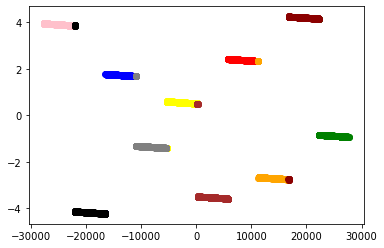

In [4]:

df_genres_encoded = read_csv_file("C:/Users/Alina/Master-Projects/visual-data-science/project/data/trakcs_genres_encoded.csv")
df_genres_clustering = df_genres_encoded.drop(columns=['track_id', 'name'])
print(df_genres_encoded.columns)
kmeans = KMeans(n_clusters=10).fit(df_genres_clustering)

centroids = kmeans.cluster_centers_
cluster_assignments = kmeans.labels_

df_genres_encoded['cluster'] = cluster_assignments

pca = PCA(2)
df_plot = pca.fit_transform(df_genres_clustering)
df_plot = np.column_stack((df_plot, cluster_assignments))

group0 = df_plot[df_plot[:,2] == 0]
group1 = df_plot[df_plot[:,2] == 1]
group2 = df_plot[df_plot[:,2] == 2]
group3 = df_plot[df_plot[:,2] == 3]
group4 = df_plot[df_plot[:,2] == 4]
group5 = df_plot[df_plot[:,2] == 5]
group6 = df_plot[df_plot[:,2] == 6]
group7 = df_plot[df_plot[:,2] == 7]
group8 = df_plot[df_plot[:,2] == 8]
group9 = df_plot[df_plot[:,2] == 9]

plt.scatter(group0[:,0], group0[:, 1], color="red")
plt.scatter(group1[:,0], group1[:, 1], color="blue")
plt.scatter(group2[:,0], group2[:, 1], color="green")
plt.scatter(group3[:,0], group3[:, 1], color="yellow")
plt.scatter(group4[:,0], group4[:, 1], color="pink")
plt.scatter(group5[:,0], group5[:, 1], color="brown")
plt.scatter(group6[:,0], group6[:, 1], color="orange")
plt.scatter(group7[:,0], group7[:, 1], color="black")
plt.scatter(group8[:,0], group8[:, 1], color="gray")
plt.scatter(group9[:,0], group9[:, 1], color="darkred")




print(cluster_assignments.shape)
print(df_genres_encoded)

df_genres_encoded.to_csv("C:/Users/Alina/Master-Projects/visual-data-science/project/data/trakcs_genres_encoded.csv")


Columns in CSV file:
Index(['Unnamed: 0', 'Unnamed: 0_x', 'index', 'track_id', 'streams', 'country',
       'artists', 'artist_genres', 'duration', 'name', 'date', 'position',
       'Unnamed: 0_y', 'acousticness', 'danceability', 'duration_ms',
       'instrumentalness', 'key', 'energy', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')


C:\Users\Alina\AppData\Local\Temp\ipykernel_22944\2992797884.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['tempo'] = tempi_normalized
C:\Users\Alina\AppData\Local\Temp\ipykernel_22944\2992797884.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['mode'] = modes_normalized


(24027, 3)


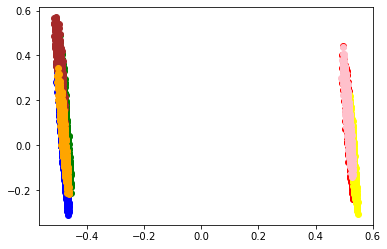

In [6]:
df = read_csv_file("C:/Users/Alina/Master-Projects/visual-data-science/project/data/charts_with_detail.csv")
df = df.drop_duplicates(subset='track_id', keep='first')


df_clusters = df
features = df_clusters[["acousticness","danceability","energy", "mode", "tempo",
                       "speechiness","valence", "instrumentalness"]]
tempi = features['tempo']
modes = features['mode']

tempi_normalized = (tempi-tempi.min()) / (tempi.max() - tempi.min())
modes_normalized = (modes - modes.min()) / (modes.max() - modes.min())

features['tempo'] = tempi_normalized
features['mode'] = modes_normalized

df['tempo'] = tempi_normalized
df['mode'] = modes_normalized

kmeans = KMeans(n_clusters= 20)
prediciton = kmeans.fit(features)

labels =  prediciton.labels_

pca = PCA(n_components=2)
df_plot = pca.fit_transform(features)

df_clusters['cluster'] = labels
df['cluster'] = labels
df_plot = np.column_stack((df_plot, labels))
print(df_plot.shape)
group0 = df_plot[df_plot[:,2] == 0]
group1 = df_plot[df_plot[:,2] == 1]
group2 = df_plot[df_plot[:,2] == 2]
group3 = df_plot[df_plot[:,2] == 3]
group4 = df_plot[df_plot[:,2] == 4]
group5 = df_plot[df_plot[:,2] == 5]
group6 = df_plot[df_plot[:,2] == 6]
group7 = df_plot[df_plot[:,2] == 7]
group8 = df_plot[df_plot[:,2] == 8]
group9 = df_plot[df_plot[:,2] == 9]

plt.scatter(group0[:,0], group0[:, 1], color="red")
plt.scatter(group1[:,0], group1[:, 1], color="blue")
plt.scatter(group2[:,0], group2[:, 1], color="green")
plt.scatter(group3[:,0], group3[:, 1], color="yellow")
plt.scatter(group4[:,0], group4[:, 1], color="pink")
plt.scatter(group5[:,0], group5[:, 1], color="brown")
plt.scatter(group6[:,0], group6[:, 1], color="orange")

df.to_csv("C:/Users/Alina/Master-Projects/visual-data-science/project/data/charts_with_detail_clustered.csv")

In [28]:
group = df[df['cluster'] == 2].sample(8)
group_other = df[df['cluster'] == 4].sample(8)

for _, row in group.iterrows():
    print(f"{row['name']}, artists: {row['artists']}")

print("other group")
for _, row in group_other.iterrows():
    print(f"{row['name']}, artists: {row['artists']}")

Tulevaisuuteen, artists: ['Nelli Matula']
Pilkun jälkeen, artists: ['Roope Salminen & Koirat']
La Boca, artists: ['Mau y Ricky', 'Camilo']
Love Not War (The Tampa Beat), artists: ['Jason Derulo', 'Nuka']
Juju on That Beat (TZ Anthem), artists: ['Zay Hilfigerrr', 'Zayion McCall']
Fester Skank, artists: ['Lethal Bizzle', 'Diztortion']
Svin på rutin, artists: ['Victor och Natten']
Mírame - Remix, artists: ['Nio Garcia', 'Rauw Alejandro', 'Lenny Tavárez', 'Myke Towers', 'Casper Magico', 'Darell']
other group
Sturmmaske Auf [Intro], artists: ['Kollegah', 'Farid Bang']
B.L.F.L., artists: ['Azet', 'Capital Bra']
King, artists: ['Kollegah']
Улицы, artists: ['BATO', 'Boulevard Depo']
Ke Lo Ke (feat. Lazza & Gazo), artists: ['Tony Effe', 'Lazza', 'Gazo']
Hensigt, artists: ['Artigeardit']
Sensei (feat. MellemFingaMuzik), artists: ['Sivas', 'MellemFingaMuzik']
Ricchi x Sempre, artists: ['Sfera Ebbasta']


In [4]:
df = read_csv_file("../data/charts_monthly_top_50.csv")
print(df['country'].unique())
selected_countries = ['at', 'de', 'gb', 'global', 'us', 'ca', 'cy', 'jp', 'mx', 'au', 'eg']
df = df[df['country'].isin(selected_countries)]
df_details = read_csv_file('../data/detail_info_monthly_top_50.csv')
df_merged = pd.merge(df, df_details, how='left', on="track_id")
df_merged = df_merged.drop(columns=["position"])
df_merged = df_merged.dropna(subset=['name'])
df_merged.to_csv('../data/charts_monthly_top_50_with_details_shortened.csv')

Columns in CSV file:
Index(['Unnamed: 0', 'index', 'track_id', 'streams', 'country', 'artists',
       'artist_genres', 'duration', 'name', 'date', 'position'],
      dtype='object')
['ar' 'at' 'au' 'be' 'bg' 'ch' 'cl' 'co' 'cr' 'cz' 'de' 'dk' 'do' 'ec'
 'ee' 'es' 'fi' 'fr' 'gb' 'global' 'gr' 'gt' 'hk' 'hn' 'hu' 'ie' 'is' 'it'
 'lt' 'lu' 'lv' 'mt' 'mx' 'my' 'nl' 'no' 'nz' 'pa' 'pe' 'pl' 'pt' 'se'
 'sg' 'sk' 'sv' 'tr' 'tw' 'us' 'uy' 'py' 'bo' 'br' 'ni' 'cy' 'ph' 'ad'
 'ca' 'id' 'jp' 'th' 'il' 'ro' 'vn' 'in' 'ae' 'eg' 'ma' 'sa' 'za' 'ru'
 'ua' 'kr' 'by' 'kz' 'ng' 've' 'pk']
Columns in CSV file:
Index(['Unnamed: 0', 'track_id', 'acousticness', 'danceability', 'duration_ms',
       'instrumentalness', 'key', 'energy', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')
